In [59]:
%matplotlib inline

import time
import tarfile
import re
import io

import numpy
import pandas
import matplotlib.pyplot as plt

import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn import metrics

import librosa
import librosa.display

In [2]:

def load_dataset(featurespath, labelpath=None, datadir='data/'):    
    features = pandas.read_csv(datadir+featurespath)
    #regex = re.compile(r'wav\/(.*).wav')
    #itemid = features.filename.astype('str').str.replace(pat=regex, repl=lambda m: m.group(1), regex=True)
    itemid = features.filename.str.replace('.wav', '', regex=False).str.replace('wav/', '')
    itemid = itemid.str.replace('PolandNFC_test_', '')
    itemid = itemid.str.replace('wabrlrb10k_test_', '')
    itemid = itemid.str.replace('chern_', '')
    features.index = itemid

    data = features.copy()
    
    if labelpath:
        labels = pandas.read_csv(datadir+labelpath, index_col='itemid')
        labels.index = labels.index.astype('str')
        data['hasbird'] = labels.hasbird.astype('bool')

    return data


In [3]:
train_ff1010 = load_dataset('ff1010bird_wav.melmax.csv', 'ff1010bird.labels.csv')
train_warblr = load_dataset('warblrb10k_public_wav.melmax.csv', 'warblrb10k.labels.csv')
predict_poland = load_dataset('PolandNFC_test_wav.melmax.csv')
predict_warblr = load_dataset('wabrlrb10k_test_wav.melmax.csv')
predict_chern = load_dataset('chern_wav.melmax.csv')

compete = pandas.concat([predict_warblr, predict_chern, predict_poland])

dataset = pandas.concat([train_ff1010, train_warblr])
print('training', dataset.shape)
print('competition', compete.shape)

training (15690, 66)
competition (12620, 65)


In [4]:
def plot_precision_recall(Y_test, Y_score):
    average_precision = metrics.average_precision_score(Y_test, Y_score)
    precision, recall, _ = metrics.precision_recall_curve(Y_test, Y_score)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [89]:
X.shape
X.iloc[:,numpy.array(best_features)].shape

(15690, 24)

In [90]:
label_columns = ['hasbird']
ignore_columns = ['filename']
feature_columns = list(set(dataset.columns) - set(label_columns) - set(ignore_columns))
X = dataset[feature_columns]

X = X.iloc[:,numpy.array(best_features)]

Y = dataset[label_columns[0]]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=1)
print('dataset', X.shape, Y.shape, numpy.mean(Y))

rf = make_pipeline(
    RandomForestClassifier(n_estimators=100, random_state=1),
)

start = time.time()
rf.fit(X_train, Y_train)
end = time.time()
print('Train time', end-start)

train = model_selection.cross_val_score(rf, X_train, Y_train, scoring='roc_auc', cv=5)
print('Train score: {:.4f} {:.4f} ||'.format(numpy.mean(train), numpy.std(train)), train)

test = model_selection.cross_val_score(rf, X_test, Y_test, scoring='roc_auc', cv=5)
print('Test score: {:.4f} {:.4f} ||'.format(numpy.mean(test), numpy.std(test)), test)

# test
Y_pred = rf.predict(X_test)
recall = metrics.recall_score(Y_test, Y_pred)
print('recall', recall)

metrics.confusion_matrix(Y_test, Y_pred)

dataset (15690, 24) (15690,) 0.5086042065009561
Train time 12.55774188041687
Train score: 0.8334 0.0059 || [0.84386327 0.82582143 0.83335337 0.83229964 0.83153654]
Test score: 0.8312 0.0160 || [0.82264094 0.86236955 0.828534   0.82429185 0.81805963]
recall 0.7718855218855218


array([[1771,  560],
       [ 542, 1834]])

In [91]:
cf = metrics.confusion_matrix(Y_test, Y_pred)
numpy.round(cf / cf.sum(axis=0), 4)*100

array([[76.57, 23.39],
       [23.43, 76.61]])

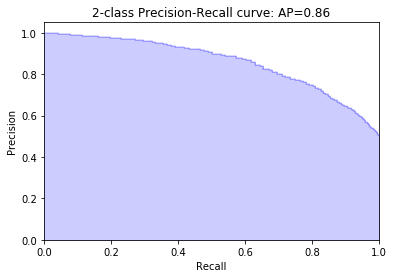

In [92]:
plot_precision_recall(Y_test, rf.predict_proba(X_test)[:,1])

order [ 6  7 48 38 39 60 57 21 61 10 31  4 51 25 13 16 24 37 47 23 62 53 50 22
  0  2  8  5 54 40  1 12 36 56 20 52 32 63 46 35 58 59 34  3 18 15 45 44
 30 26 11 49 42 28 43 27 14 41 55 19 17  9 29 33]


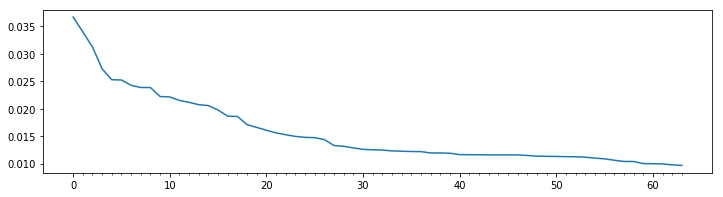

In [87]:
importance = rf.steps[0][1].feature_importances_
order = numpy.argsort(importance)[::-1]
print('order', order)
f = plt.figure(figsize=(12,3))
p = f.add_subplot(111)
x = list(range(len(importance)))
p.plot(x, importance[order])
tt = [str(t) for t in order]
p.set_xticks(x, tt)
None

In [88]:
best_features = list(order[:24])
best_features

[6,
 7,
 48,
 38,
 39,
 60,
 57,
 21,
 61,
 10,
 31,
 4,
 51,
 25,
 13,
 16,
 24,
 37,
 47,
 23,
 62,
 53,
 50,
 22]

In [94]:
X_compete = compete[feature_columns]
X_compete = X_compete.iloc[:,numpy.array(best_features)]
df = pandas.DataFrame({
    'item': X_compete.index, 
    'prediction': rf.predict(X_compete).astype('int'),
})

# check all items correctly named
example = pandas.read_csv('example.csv', header=None)
diff = set(example[0]).symmetric_difference(df.item)
assert diff == set()

df.to_csv('prediction.csv', index=False, header=False)